#### Objetivos: 

* crear un df con selección de variables del notebook de regresión 
* guardarlo en csv 
* emplear pycaret reg 
* evaluar modelos y crear pkl 
* crear app de streamlit de predicción de precios crear proyecto github

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Setup

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read data:


* crear un df con selección de variables del notebook de regresión 
* guardarlo en csv 

In [4]:
datos = pd.read_csv('train.csv')

<AxesSubplot: >

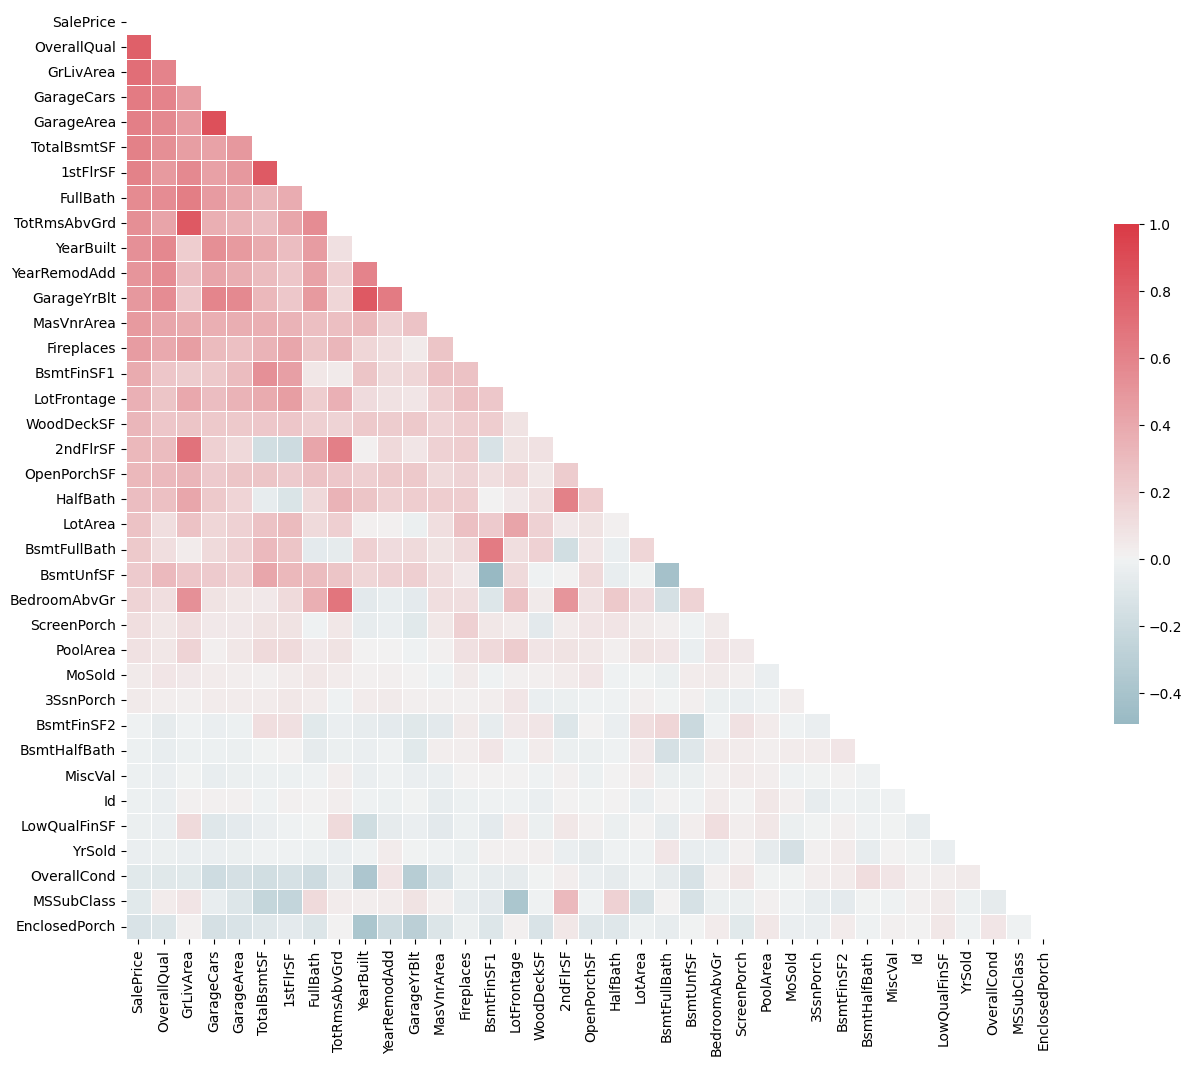

In [5]:
# A grandes rasgos, hacemos un heatmap para ver cuáles son las variables que tienen más correlación con el Saleprice
corr = datos.corr(method = 'pearson').sort_values(by = 'SalePrice', axis = 0, ascending = False).sort_values(by = 'SalePrice', axis = 1, ascending = False)
mask = np.triu(np.ones_like(corr, dtype=bool)) 

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap. Personalizar los colores.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr.iloc[0:37,0:37], mask=mask[0:37,0:37], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False)

In [19]:
#Selección de las 10 primeras variables más correlacionadas con el 'SalePrice'
variables = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','GarageCars', 'GrLivArea', '1stFlrSF','FullBath', 'TotRmsAbvGrd', 'SalePrice']
df = datos[variables]

#Pasamos a csv
df.to_csv('datos_casas_app.csv', index=False)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1460 non-null   int64
 1   YearBuilt     1460 non-null   int64
 2   YearRemodAdd  1460 non-null   int64
 3   TotalBsmtSF   1460 non-null   int64
 4   GarageCars    1460 non-null   int64
 5   GrLivArea     1460 non-null   int64
 6   1stFlrSF      1460 non-null   int64
 7   FullBath      1460 non-null   int64
 8   TotRmsAbvGrd  1460 non-null   int64
 9   SalePrice     1460 non-null   int64
dtypes: int64(10)
memory usage: 114.2 KB


* emplear pycaret reg 

In [21]:
from pycaret.regression import *

In [22]:
#Nos prepara un entorno donde el objetivo es la columna SalePrice
regexperiment = setup(df, target='SalePrice') 

,Description,Value
0,Session id,3074
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 10)"
4,Transformed data shape,"(1460, 10)"
5,Transformed train set shape,"(1021, 10)"
6,Transformed test set shape,"(439, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple



* evaluar modelos y crear pkl 


In [23]:
#Evaluar qué modelo funciona mejor:
best_models = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,20888.6499,1232827893.9020,33599.6027,0.7880,0.1694,0.1241,0.1510
et,Extra Trees Regressor,20993.4512,1280347918.1606,33798.8378,0.7724,0.1719,0.1258,0.1780
rf,Random Forest Regressor,21106.2994,1355795132.7367,34318.0170,0.7557,0.1713,0.1267,0.3210
gbr,Gradient Boosting Regressor,20766.1928,1449969304.5672,34939.0987,0.7416,0.1705,0.1240,0.1310
huber,Huber Regressor,25398.3355,1762275474.7519,40766.9960,0.7020,0.2077,0.1509,0.0290
lar,Least Angle Regression,25447.5827,1835607749.7284,40869.8580,0.6828,0.2106,0.1526,0.0150
llar,Lasso Least Angle Regression,25447.3032,1835595769.6465,40869.7217,0.6828,0.2106,0.1526,0.0150
br,Bayesian Ridge,25341.6100,1834807612.7990,40839.4623,0.6828,0.2082,0.1514,0.0150
ridge,Ridge Regression,25441.5701,1835494105.2172,40867.5578,0.6828,0.2104,0.1525,0.0150
lasso,Lasso Regression,25447.3033,1835595840.5031,40869.7221,0.6828,0.2106,0.1526,0.0150


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [32]:
# Elegimos el modelo lightgbm porque es el que tiene más casillas en amarillo
model_lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,23161.3298,1981458199.5654,44513.5732,0.7873,0.2082,0.1472
1,22230.8301,946539358.7610,30765.8798,0.8390,0.1700,0.1333
2,18751.6317,698141347.9934,26422.3645,0.8808,0.1471,0.1095
3,22140.2162,1177435982.8488,34313.7871,0.8466,0.1720,0.1303
4,19992.1756,1022339505.0788,31974.0442,0.7897,0.1731,0.1243
5,20048.4483,754235086.1899,27463.3408,0.8807,0.1532,0.1138
6,18629.7933,866192139.4097,29431.1423,0.8626,0.1424,0.1080
7,17586.8854,639195641.1940,25282.3187,0.9075,0.1585,0.1101
8,27565.2185,3556783661.8076,59638.7765,0.2496,0.2282,0.1615


In [33]:
# Evaluamos qué hiperparámetros son los más adecuados
tunedlightgbm = tune_model(model_lightgbm)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:24:12
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22480.4386,1803413409.7845,42466.6152,0.8064,0.2110,0.1470
1,22319.8465,1016484253.8733,31882.3502,0.8271,0.1710,0.1363
2,18853.0573,694180162.6574,26347.2990,0.8815,0.1444,0.1095
3,21107.1141,1186976625.6026,34452.5271,0.8454,0.1698,0.1238
4,19547.3080,1006364741.0848,31723.2524,0.7930,0.1772,0.1255
5,19080.1307,710280445.0366,26651.0871,0.8876,0.1383,0.1063
6,16631.7691,739136145.2612,27187.0584,0.8828,0.1319,0.0991
7,16470.6810,639903173.5497,25296.3075,0.9074,0.1572,0.1077
8,25833.6117,2587412061.7012,50866.6105,0.4541,0.2078,0.1488


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [34]:
# Evaluamos nuestro modelo tuneado
evaluate_model(tunedlightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [35]:
predictions = predict_model(tunedlightgbm)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [36]:
modelo_final = finalize_model(tunedlightgbm)


In [37]:
save_model(modelo_final, 'modelito2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['OverallQual', 'YearBuilt',
                                              'YearRemodAdd', 'TotalBsmtSF',
                                              'GarageCars', 'GrLivArea',
                                              '1stFlrSF', 'FullBath',
                                              'TotRmsAbvGrd'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=1.0, bagging_freq=6,
                                feature_fraction=0.7, learning_rate=0.05,
                                min_child_samples=21, min_split_gain=0.7,
                                n_estimators=90, n_jobs=-1